In [14]:
import logging
import time
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn, optim
import torch.nn.functional
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import datasets
from torchvision.transforms import ToTensor, Normalize, Compose, Lambda
from torch.nn.functional import normalize

import matplotlib.pyplot as plt

In [2]:
# Set hardware

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

In [3]:
def GlobalContrastNormalization(tensor: torch.tensor, scale='l2'):
    assert scale in ('l1', 'l2')
    n_features = int(np.prod(tensor.shape))
            
    tensor = tensor - torch.mean(tensor)
    
    if (scale == 'l1'):
        tensor = tensor / torch.mean(torch.abs(tensor))
    
    if (scale == 'l2'):
        tensor = tensor / torch.sqrt(torch.sum(tensor ** 2) / n_features)
    
    return tensor

In [4]:
def get_target_label_idx(labels, targets):
    """
    Get the indices of labels that are included in targets.
    :param labels: array of labels
    :param targets: list/tuple of target labels
    :return: list with indices of target labels
    """
    return [idx for idx, label in enumerate(labels) if label in targets]

In [5]:
normal_class = 0

n_classes = 2
normal_classes = tuple([normal_class])
outlier_classes = list(range(0, 10))
outlier_classes.remove(normal_class)

min_max = [(-0.8826567065619495, 9.001545489292527),
           (-0.6661464580883915, 20.108062262467364),
           (-0.7820454743183202, 11.665100841080346),
           (-0.7645772083211267, 12.895051191467457),
           (-0.7253923114302238, 12.683235701611533),
           (-0.7698501867861425, 13.103278415430502),
           (-0.778418217980696, 10.457837397569108),
           (-0.7129780970522351, 12.057777597673047),
           (-0.8280402650205075, 10.581538445782988),
           (-0.7369959242164307, 10.697039838804978)]

transform = Compose([ToTensor(), 
                     Lambda(lambda x: GlobalContrastNormalization(x, scale='l1')), 
                     Normalize([min_max[normal_class][0]], 
                               [min_max[normal_class][1] - min_max[normal_class][0]])])
target_transform = Lambda(lambda x: int(x in outlier_classes))

training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=transform,
    target_transform=target_transform,
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=transform,
    target_transform=target_transform,
)

train_idx_normal = get_target_label_idx(training_data.train_labels.clone().data.cpu().numpy(), normal_classes)
train_data = Subset(training_data, train_idx_normal)

C:\Users\btdat\AppData\Local\miniconda3\envs\Deep_OOC\lib\site-packages\torchvision\datasets\mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


In [6]:
class MNIST_LeNet_AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.rep_dim = 32
        self.pool = nn.MaxPool2d(2, 2)
        
        # Encoder: Same as Deep Out-of-Context (OOC) network
        self.conv1 = nn.Conv2d(1, 8, 5, bias=False, padding=2)
        self.bn1 = nn.BatchNorm2d(8, eps=1e-04, affine=False)
        self.conv2 = nn.Conv2d(8, 4, 5, bias=False, padding=2)
        self.bn2 = nn.BatchNorm2d(4, eps=1e-04, affine=False)
        self.fc1 = nn.Linear(4 * 7 * 7, self.rep_dim, bias=False)
        
        # Decoder
        self.deconv1 = nn.ConvTranspose2d(2, 4, 5, bias=False, padding=2)
        self.bn3 = nn.BatchNorm2d(4, eps=1e-04, affine=False)
        self.deconv2 = nn.ConvTranspose2d(4, 8, 5, bias=False, padding=3)
        self.bn4 = nn.BatchNorm2d(8, eps=1e-04, affine=False)
        self.deconv3 = nn.ConvTranspose2d(8, 1, 5, bias=False, padding=2)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(nn.functional.leaky_relu(self.bn1(x)))
        x = self.conv2(x)
        x = self.pool(nn.functional.leaky_relu(self.bn2(x)))
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = x.view(x.size(0), int(self.rep_dim / 16), 4, 4)
        x = nn.functional.interpolate(nn.functional.leaky_relu(x), scale_factor=2)
        x = self.deconv1(x)
        x = nn.functional.interpolate(nn.functional.leaky_relu(self.bn3(x)), scale_factor=2)
        x = self.deconv2(x)
        x = nn.functional.interpolate(nn.functional.leaky_relu(self.bn4(x)), scale_factor=2)
        x = self.deconv3(x)
        x = torch.sigmoid(x)
        
        return x

In [7]:
class MNIST_LeNet_Network(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.rep_dim = 32
        self.pool = nn.MaxPool2d(2, 2)
        
        self.conv1 = nn.Conv2d(1, 8, 5, bias=False, padding=2)
        self.bn1 = nn.BatchNorm2d(8, eps=1e-04, affine=False)
        self.conv2 = nn.Conv2d(8, 4, 5, bias=False, padding=2)
        self.bn2 = nn.BatchNorm2d(4, eps=1e-04, affine=False)
        self.fc1 = nn.Linear(4 * 7 * 7, self.rep_dim, bias=False)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(nn.functional.leaky_relu(self.bn1(x)))
        x = self.conv2(x)
        x = self.pool(nn.functional.leaky_relu(self.bn2(x)))
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

In [8]:
# Configuration for Pretrain and Train
optimizer_name: str = 'adam'
lr: float = 0.001
n_epochs: int = 150
lr_milestones: tuple = ()
batch_size: int = 128
weight_decay: float = 1e-6
n_jobs_dataloader: int = 0

ae_net = MNIST_LeNet_AutoEncoder().to(device)
net = MNIST_LeNet_Network().to(device)

In [9]:
model_dict = torch.load('saved_model/model.tar')

R = model_dict['R']
c = model_dict['c']
net.load_state_dict(model_dict['net_dict'])
ae_net.load_state_dict(model_dict['ae_net_dict'])

<All keys matched successfully>

In [10]:
def fgsm(model, X, y, epsilon):
    """ Construct FGSM adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    loss = nn.CrossEntropyLoss()(model(X + delta), y)
    loss.backward()
    return epsilon * delta.grad.detach().sign()


In [11]:
train_loader = DataLoader(train_data, batch_size, num_workers=n_jobs_dataloader)
test_loader = DataLoader(test_data, batch_size, num_workers=n_jobs_dataloader)
        

In [17]:
for X,y in test_loader:
    X,y = X.to(device), y.to(device)
    break
    
def plot_images(X,y,yp,M,N):
    f,ax = plt.subplots(M,N, sharex=True, sharey=True, figsize=(N,M*1.3))
    dist = torch.sum((yp - c) ** 2, dim=1)
    for i in range(M):
        for j in range(N):
            ax[i][j].imshow(1 - X[i*N+j][0].cpu().numpy(), cmap="gray")
            yp = outputs[i*N+j].max(dim=0)[1]
            title_text = "Pred: {}\nDist: {:.2f}".format(yp, scores[i*N+j])
            title = ax[i][j].set_title(title_text)
            plt.setp(title, color=('g' if yp == y[i*N+j] else 'r'))
            ax[i][j].set_axis_off()
    plt.tight_layout()



In [ ]:
with torch.no_grad():
    for data in test_loader:
            inputs, labels = data
            inputs = inputs.to(device)
            outputs = ae_net(inputs)
            scores = torch.sum((outputs - inputs) ** 2, dim=tuple(range(1, outputs.dim())))

TypeError: unsupported operand type(s) for -: 'Tensor' and 'list'

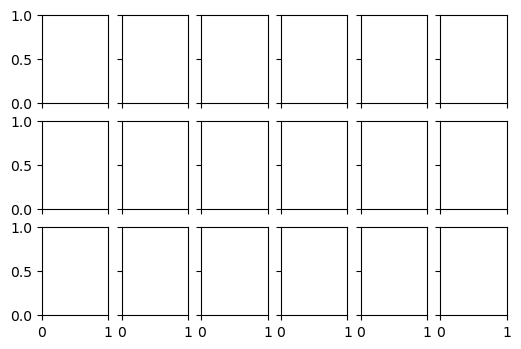

In [18]:
### Illustrate original predictions
yp = net(X)
plot_images(X, y, yp, 3, 6)
